In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from waymo_open_dataset import dataset_pb2 as open_dataset
import matplotlib.pyplot as plt
import dask.dataframe as dd
import tensorflow as tf
from waymo_open_dataset import v2
import time
from typing import Any, Dict, Iterator, List, Optional, Sequence, Tuple
from waymo_open_dataset.utils import camera_segmentation_utils
import cv2
tf.compat.v1.enable_eager_execution()


class PanopticSegmentationDataset(Dataset):
    def __init__(self, frames_path, labels_path, frames_id_list_path, datasetNum=None, desired_context_name=None, desired_timestamp=None, transform=None):
        self.frames_path = frames_path
        self.labels_path = labels_path
        self.frames_context_list = self.get_frames_context_list(frames_id_list_path, datasetNum, desired_context_name, desired_timestamp)
        self.transform = transform
        self.camera_name_list = {
            1 : "FRONT",
            2 : "FRONT_LEFT",
            3 : "FRONT_RIGHT",
            4 : "SIDE_LEFT",
            5 : "SIDE_RIGHT"
        }
        print("Data prepared to be imported: ", len(self.frames_context_list), " frames.")
        for line in self.frames_context_list:
            print("context_name: ", line[0], "Timestamp: ", line[1])
        
        self.frames_list = [] # a list, each item is a list[(img1, "FRONT"), ..., (img5, "SIDE_RIGHT")] at one time step
        self.labels_list = [] # a list, each item is a list[[img1_label_semantic, img1_label_instance, img1_panoptic_label, "FRONT"], ..., (img5_label_semantic, img5_label_instance, "SIDE_RIGHT")] at one time step
        # end  = 0
        # start = 0
        # for line in self.frames_context_list:
        #     context_name, time_stamp = line
        #     start = time.time()
        #     self.load_frames_from_parquet(context_name, time_stamp)
        #     self.load_labels_from_parquet(context_name, time_stamp)
        #     end = time.time()
        #     print(round(end-start, 2), "s, imported ", context_name, time_stamp)
            
        # print("Imported Done!")
        # print("Num of frames, ", len(self.frames_list))
        # assert(len(self.frames_list) == len(self.labels_list)) # the number of timestamps should match
        
        
    def __len__(self):
        return len(self.frames_context_list)
    
    def __getitem__(self, index):
        """
        get a frame (containing multiple cameras) for one time step
        """
        context_name, time_stamp = self.frames_context_list[index]
        self.load_frames_from_parquet(context_name, time_stamp)
#         self.load_labels_from_parquet(context_name, time_stamp)
        self.labels_list.append([None, None, None])
    
        frames = self.frames_list[-1]# a list of tuple:(rgb input images, camera_num): [(img1, FRONT), (img2, FRONT_LEFT),...,(img5, SIDE_RIGHT)]
        labels = self.labels_list[-1]# a list of 3-tems:(semantic_labels, instance_labels, camera_num):
        
        self.frames_list.pop(0)
        self.labels_list.pop(0)
        # apply transform
        if self.transform:
            frames = [(self.transform(img), camera_name) for (img, camera_name) in frames]  
#             labels = [(self.transform(semantic_label), self.transform(instance_label), self.transform(panoptic_label), camera_name) for (semantic_label, instance_label, panoptic_label, camera_name) in labels]
        
        return frames, labels
    
    def load_frames_from_parquet(self, context_name, desired_time_stamp):
        """
        Given context name and time_stamp, fetch parquet file, filter with desired timestamp
        
        In theory, in the filtered df, for each unique timestamp, there's 5 images corresponding to 5 cameras
        
        for each unique timestamp, append a list[(img1, "FRONT"), ..., (img5, "SIDE_RIGHT")] to self.frames_list
        
        """
        
        camera_image_df = dd.read_parquet(tf.io.gfile.glob(f'{self.frames_path}/{context_name}.parquet'))
        filtered_camera_image_df = camera_image_df[camera_image_df['key.frame_timestamp_micros'] == (desired_time_stamp)]
        frames_for_one_timestamp = []
        collected_cameras = [] # to determine if we need to move on and wrap next timestamp
        for i, (key_values, row) in enumerate(filtered_camera_image_df.iterrows()):
            # In theory, there's five iterations since there's 5 cameras for each desired timestamp
            camera_image = v2.CameraImageComponent.from_dict(row)
            data_time_stamp = camera_image.key.frame_timestamp_micros
            camera_name = self.camera_name_list[camera_image.key.camera_name]
            image = tf.image.decode_jpeg(camera_image.image)
            image = image.numpy()
            image = np.int32(image)
            collected_cameras.append(camera_name)
            frames_for_one_timestamp.append((image, camera_image.key.camera_name))
        # The end, append all frames in this timestamp to global frames_list
        frames_for_one_timestamp = sorted(frames_for_one_timestamp, key=lambda frames_for_one_timestamp: frames_for_one_timestamp[1])
        frames_for_one_timestamp = [(image, self.camera_name_list[camera_num]) for (image, camera_num) in frames_for_one_timestamp]
        self.frames_list.append(frames_for_one_timestamp)
            
    
    def load_labels_from_parquet(self, context_name, desired_time_stamp):
        """
        Given context name and time_stamp, fetch parquet file, filter with timestamp
        In theory, in the filtered df, for each unique timestamp, there's 5 camera seg component
        we decode those camera seg component,
        
        and for each timestamp, append a list to self.labels_list 
        each item is a list[[img1_label_semantic, img1_label_instance, img1_panoptic_label "FRONT"], ..., (img5_label_semantic, img5_label_instance, img5_panoptic_label "SIDE_RIGHT")] at one time step
        
        """
        cam_segmentation_df = dd.read_parquet(tf.io.gfile.glob(f'{self.labels_path}/{context_name}.parquet'))
        filtered_camera_seg_df = cam_segmentation_df[cam_segmentation_df['key.frame_timestamp_micros'] == (desired_time_stamp)]
        frame_keys = ['key.segment_context_name', 'key.frame_timestamp_micros']
        cam_segmentation_per_frame_df = filtered_camera_seg_df.groupby(frame_keys, group_keys=False).agg(list)
        # Group segmentation labels into frames by context name and timestamp.
        def ungroup_row(key_names: Sequence[str],
                        key_values: Sequence[str],
                        row: dd.DataFrame) -> Iterator[Dict[str, Any]]:
            """Splits a group of dataframes into individual dicts."""
            keys = dict(zip(key_names, key_values))
            cols, cells = list(zip(*[(col, cell) for col, cell in r.items()]))
            for values in zip(*cells):
                yield dict(zip(cols, values), **keys)

        cam_segmentation_list = []
        for i, (key_values, r) in enumerate(cam_segmentation_per_frame_df.iterrows()):
            # Store a segmentation label component for each camera.
            # each iteration: a timestamp
            cam_segmentation_list.append(
              [v2.CameraSegmentationLabelComponent.from_dict(d) 
               for d in ungroup_row(frame_keys, key_values, r)])
        camera_num_order = [open_dataset.CameraName.FRONT,
                          open_dataset.CameraName.FRONT_LEFT,
                          open_dataset.CameraName.FRONT_RIGHT,
                          open_dataset.CameraName.SIDE_LEFT,
                          open_dataset.CameraName.SIDE_RIGHT]
        segmentation_protos_ordered = []
        for it, label_list in enumerate(cam_segmentation_list):
            segmentation_dict = {label.key.camera_name: label for label in label_list}
            segmentation_protos_ordered.append([segmentation_dict[name] for name in camera_num_order])
        segmentation_protos_flat = sum(segmentation_protos_ordered, [])
        panoptic_labels, num_cameras_covered, is_tracked_masks, panoptic_label_divisor = camera_segmentation_utils.decode_multi_frame_panoptic_labels_from_segmentation_labels(
            segmentation_protos_flat, remap_to_global=True
        )
        print("panoptic_label_divisor",panoptic_label_divisor)
        NUM_CAMERA_FRAMES = 5
        for i in range(0, len(segmentation_protos_flat), NUM_CAMERA_FRAMES):
            labels = []
            for j in range(NUM_CAMERA_FRAMES):
                semantic_label, instance_label = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(panoptic_labels[i + j], panoptic_label_divisor)
                panoptic_label_rgb = camera_segmentation_utils.panoptic_label_to_rgb(semantic_label, instance_label)
                semantic_label = np.int32(semantic_label)
                instance_label = np.int32(instance_label)
                panoptic_label_rgb = np.int32(panoptic_label_rgb)
                labels.append([semantic_label, instance_label, panoptic_label_rgb, self.camera_name_list[j+1]])
            self.labels_list.append(labels)
            
    
    def get_frames_context_list(self, txtFile, datasetNum, desired_context_name, desired_timestamp):
        """
        input: txt file provided by Waymo
        
        output: a list = [
            [context_name1, timestamp1],
            [context_name1, timestamp2],
            [context_name1, timestamp3],
            ...,
            [context_name2, timestamp1],
            ...
        ]
        """
        list_ = open(txtFile).read().split()
        list_ = sorted(list_, key=lambda list_: list_[1])
        frames_context_list = []
        cutoff = datasetNum
        if(datasetNum == None):
            cutoff = len(list_)
        else:
            cutoff = datasetNum
            
        numFetchedData = 0
        for line in list_:
            if(numFetchedData >= cutoff):
                break
            frames_line = line.split(',')
            context_name, time_stamp = frames_line
            
            # if a specific context of timestamp is requested, only fetch the desired parts.
            if(desired_context_name != None and context_name != desired_context_name):
                continue
            if(desired_timestamp!= None and time_stamp != desired_timestamp):
                continue
                
            # To this point, data is allowed to be fetched.
            frames_context_list.append([context_name, int(time_stamp)])
            numFetchedData += 1
        return frames_context_list

2023-04-25 22:42:10.884722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 22:42:11.243969: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-25 22:42:12.124748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/f

2023-04-25 22:42:22.418513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 22:42:22.441079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 22:42:22.441454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 22:42:22.442190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

panoptic_label_divisor 1000
(1280, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(886, 1920, 3)
(886, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(886, 1920, 3)
(886, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(886, 1920, 3)
(886, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
(1280, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
(886, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(886, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
panoptic_label_divisor 1000
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(1280, 1920, 3)
(886, 1920, 3)
(

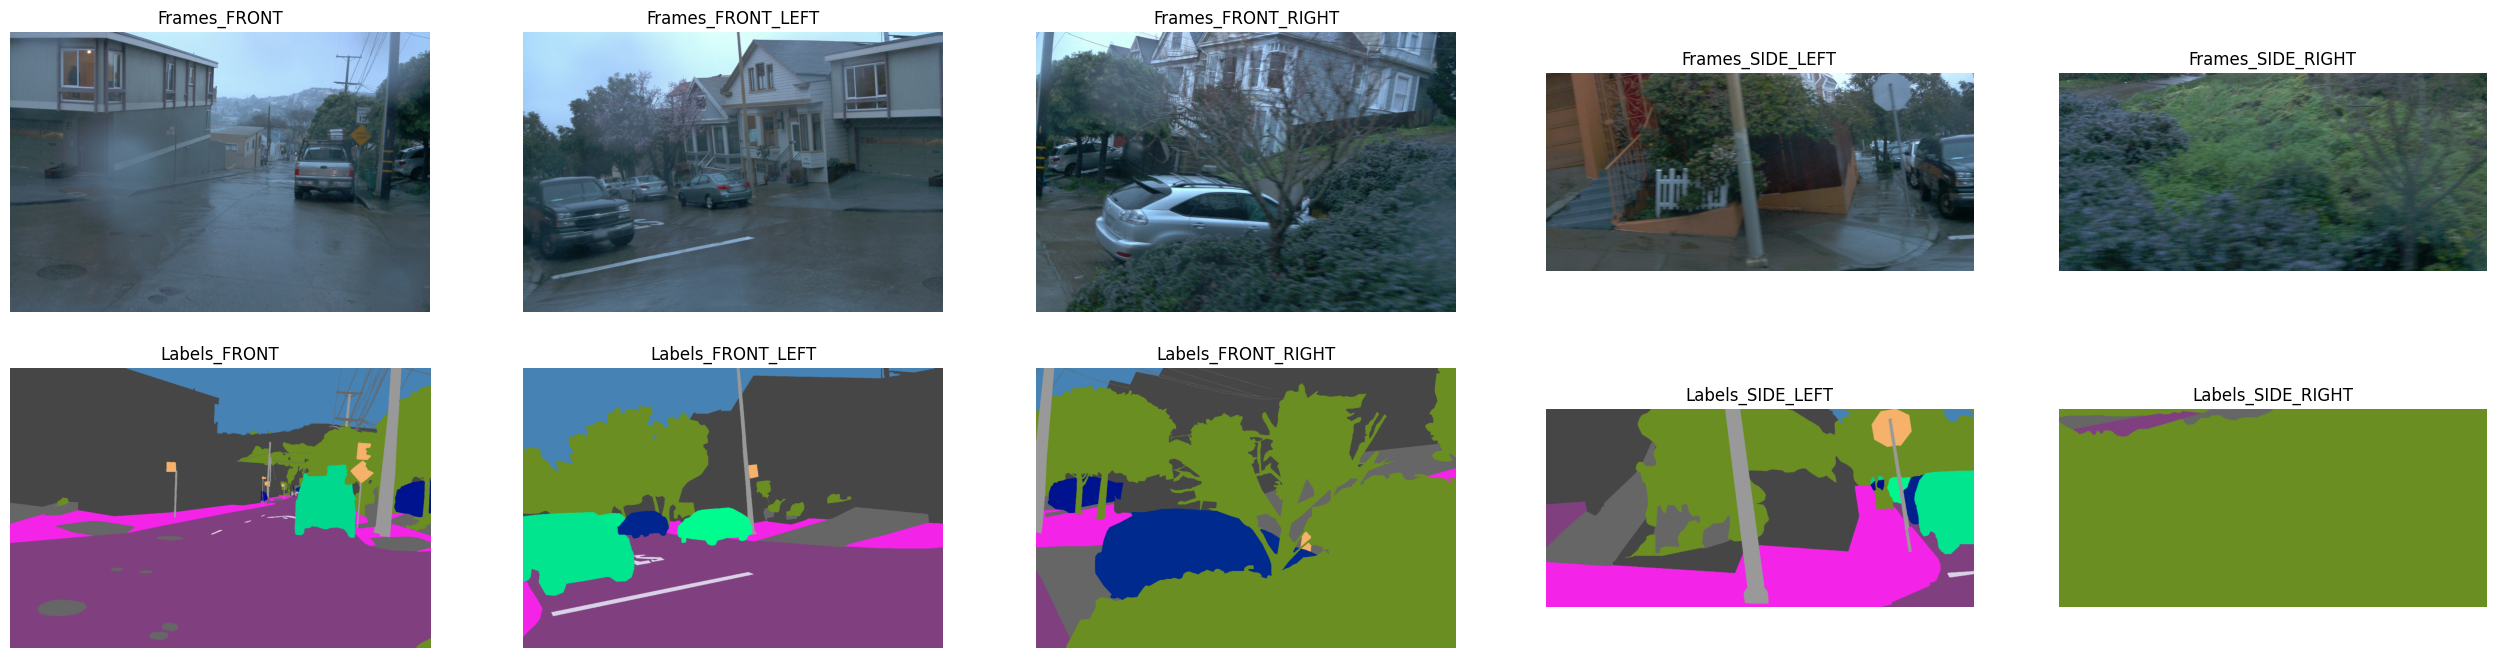

fetched batch 1, data size: 5, time elapsed:0.0003459453582763672
Visualize frames and labels for the 0 timestamp in the batch 1


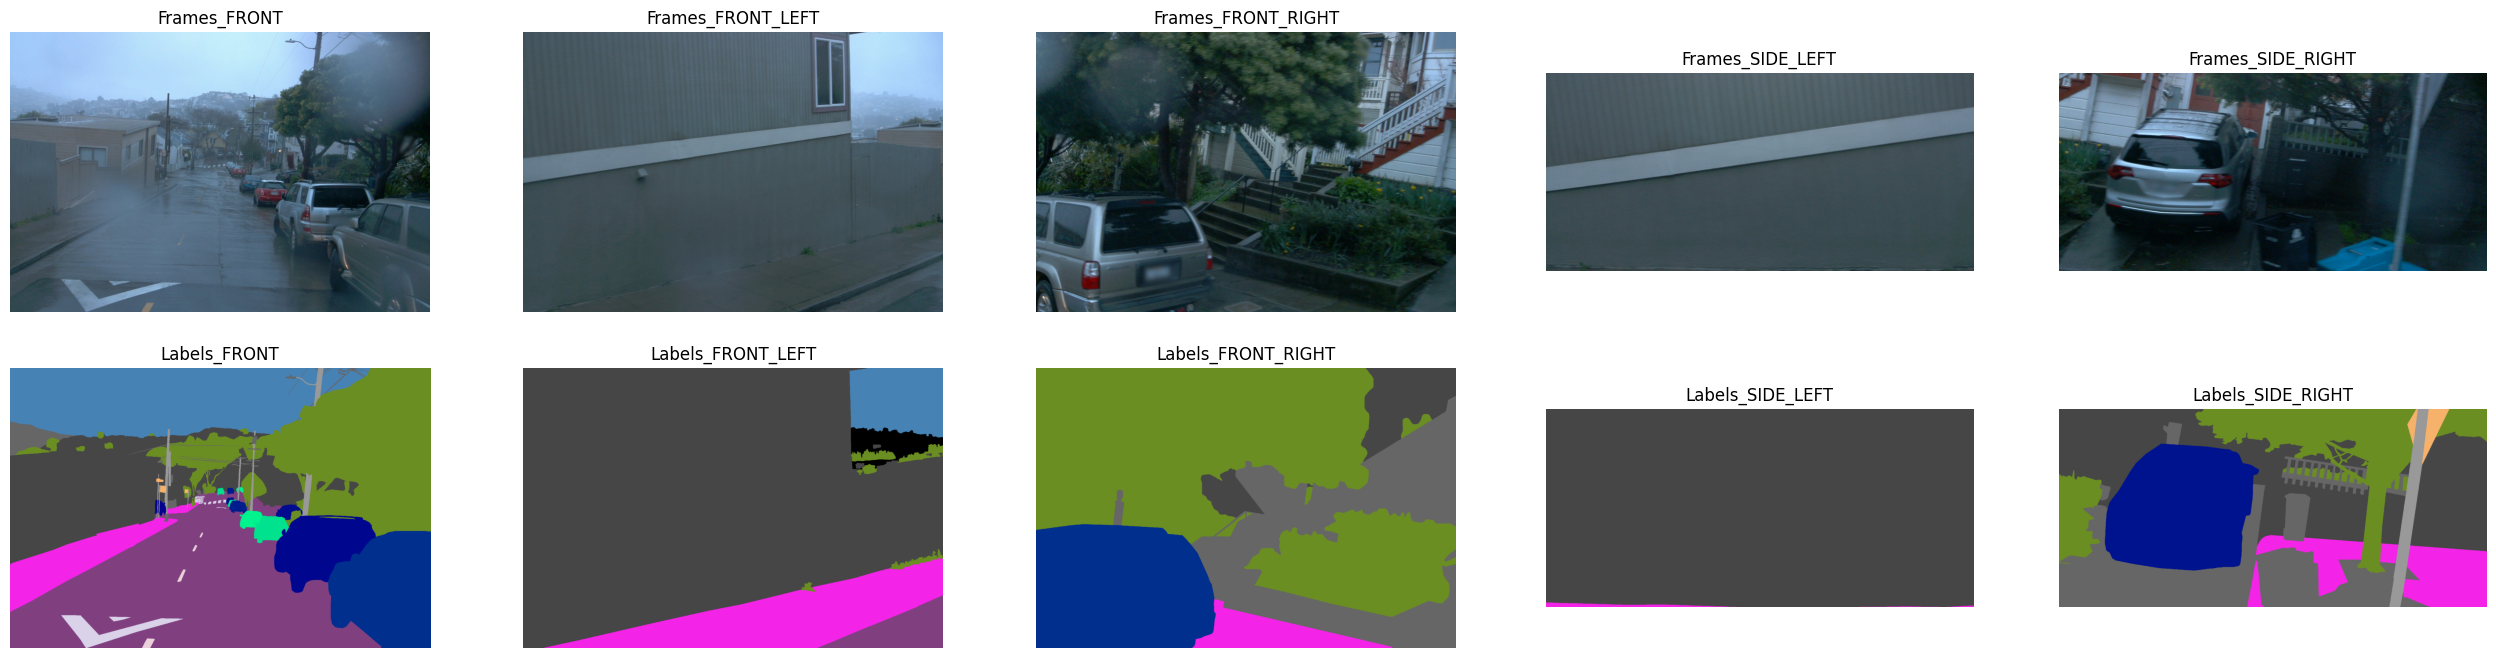

In [3]:

# I want to know what context_name is in this txt file

def getFramesList(txtFile, start_context, context_with_issue):
    context_name_list = []
    frames_dict = {}
    list_ = open(txtFile).read().split()
    start_fetching = False
    for line in list_:
        frames_line = line.split(',')
        context_name, time_stamp = frames_line
        if(context_name == start_context):
            start_fetching = True
        if(not start_fetching):
            continue
        if not(context_name in context_name_list) and not(context_name in context_with_issue):
            context_name_list.append(context_name)
        if not(context_name in frames_dict):
            frames_dict[context_name] = [time_stamp]
        else:
            frames_dict[context_name].append(time_stamp)

    for context_name in frames_dict:
        time_stamp_list = frames_dict[context_name]
        frames_dict[context_name] = sorted(time_stamp_list)
    #     print("======", context_name)
    #     print(len(frames_dict[context_name]))
    #     for time in frames_dict[context_name]:
    #         print(time)
    return context_name_list, frames_dict

context_with_issue = [
]
start_context = "10149575340910243572_2720_000_2740_000" # only append data starting from this context
txtFile = "./2d_pvps_test_frames.txt"
context_name_list, frames_dict = getFramesList(txtFile, start_context, context_with_issue)
for key in frames_dict:
    print(key)

my_transform = transforms.Compose([
    transforms.ToTensor()
])
frames_id_list_path = txtFile
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing/camera_segmentation"
datasetNum = None
desired_timestamp = None
dataset_folder = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_jpg/testing"
# For each context name, read all the data and store it in a folder
for context_name in context_name_list:
    print("Fetching context:", context_name)
    context_folder = f"{dataset_folder}/{context_name}"
    desired_context_name = context_name
    dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, datasetNum, desired_context_name, desired_timestamp, transform=my_transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, num_workers=2)
    for batch_idx, (frames, labels) in enumerate(dataloader):
        time_stamp = frames_dict[context_name][batch_idx]
        
        img_FRONT = frames[0][0][0]
        img_FRONT_LEFT = frames[1][0][0]
        img_FRONT_RIGHT = frames[2][0][0]
        img_SIDE_LEFT = frames[3][0][0]
        img_SIDE_RIGHT = frames[4][0][0]

        # torch.Size([batch_size, 1, 1280, 1920])
        semantic_labels_FRONT = labels[0][0][0]
        semantic_labels_FRONT_LEFT = labels[1][0][0]
        semantic_labels_FRONT_RIGHT = labels[2][0][0]
        semantic_labels_SIDE_LEFT = labels[3][0][0]
        semantic_labels_SIDE_RIGHT = labels[4][0][0]

        # torch.Size([batch_size, 1, 1280, 1920])
        instance_labels_FRONT = labels[0][1][0]
        instance_labels_FRONT_LEFT = labels[1][1][0]
        instance_labels_FRONT_RIGHT = labels[2][1][0]
        instance_labels_SIDE_LEFT = labels[3][1][0]
        instance_labels_SIDE_RIGHT = labels[4][1][0]

        # torch.Size([batch_size, 3, 1280, 1920])
        panoptic_rgb_labels_FRONT = labels[0][2][0]
        panoptic_rgb_labels_FRONT_LEFT = labels[1][2][0]
        panoptic_rgb_labels_FRONT_RIGHT = labels[2][2][0]
        panoptic_rgb_labels_SIDE_LEFT = labels[3][2][0]
        panoptic_rgb_labels_SIDE_RIGHT = labels[4][2][0]
        
        os.makedirs(f"{dataset_folder}/{context_name}/{time_stamp}", exist_ok=True)
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/img_FRONT.jpg", cv2.cvtColor(np.float32(img_FRONT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/img_FRONT_LEFT.jpg", cv2.cvtColor(np.float32(img_FRONT_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/img_FRONT_RIGHT.jpg", cv2.cvtColor(np.float32(img_FRONT_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/img_SIDE_LEFT.jpg", cv2.cvtColor(np.float32(img_SIDE_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/img_SIDE_RIGHT.jpg", cv2.cvtColor(np.float32(img_SIDE_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/semantic_labels_FRONT.jpg", cv2.cvtColor(np.float32(semantic_labels_FRONT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/semantic_labels_FRONT_LEFT.jpg", cv2.cvtColor(np.float32(semantic_labels_FRONT_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/semantic_labels_FRONT_RIGHT.jpg", cv2.cvtColor(np.float32(semantic_labels_FRONT_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/semantic_labels_SIDE_LEFT.jpg", cv2.cvtColor(np.float32(semantic_labels_SIDE_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/semantic_labels_SIDE_RIGHT.jpg", cv2.cvtColor(np.float32(semantic_labels_SIDE_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/instance_labels_FRONT.jpg", cv2.cvtColor(np.float32(instance_labels_FRONT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/instance_labels_FRONT_LEFT.jpg", cv2.cvtColor(np.float32(instance_labels_FRONT_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/instance_labels_FRONT_RIGHT.jpg", cv2.cvtColor(np.float32(instance_labels_FRONT_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/instance_labels_SIDE_LEFT.jpg", cv2.cvtColor(np.float32(instance_labels_SIDE_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/instance_labels_SIDE_RIGHT.jpg", cv2.cvtColor(np.float32(instance_labels_SIDE_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/panoptic_rgb_labels_FRONT.jpg", cv2.cvtColor(np.float32(panoptic_rgb_labels_FRONT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/panoptic_rgb_labels_FRONT_LEFT.jpg", cv2.cvtColor(np.float32(panoptic_rgb_labels_FRONT_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/panoptic_rgb_labels_FRONT_RIGHT.jpg", cv2.cvtColor(np.float32(panoptic_rgb_labels_FRONT_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/panoptic_rgb_labels_SIDE_LEFT.jpg", cv2.cvtColor(np.float32(panoptic_rgb_labels_SIDE_LEFT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))
        cv2.imwrite(f"{dataset_folder}/{context_name}/{time_stamp}/panoptic_rgb_labels_SIDE_RIGHT.jpg", cv2.cvtColor(np.float32(panoptic_rgb_labels_SIDE_RIGHT.permute(1, 2, 0).numpy()), cv2.COLOR_RGB2BGR))